# **Multi-Class Text Classification with Naive Bayes**

This analysis applies the **Naive Bayes algorithm** to classify over 2 million customer complaints about consumer financial products. Using **Natural Language Processing (NLP)** techniques, the aim is analyze textual data to extract meaningful insights and categorize the complaints into specific product categories.

## **Objectives**

- Learn how the Naive Bayes algorithm can be applied for text classification tasks.
- Build a multi-class classification model to categorize customer complaints.
- Apply various text preprocessing techniques including tokenization, stopword removal, and punctuation removal.
- Evaluate the performance of the model and predict product categories for new complaints.

---

## **Approach**

1. Introduction to the Naive Bayes algorithm.
2. Data description and visualization.
3. Data preprocessing:
   - Conversion to lowercase.
   - Tokenization.
   - Stopword removal.
   - Punctuation removal.
4. Building the Naive Bayes classification model.
5. Model evaluation and accuracy metrics.
6. Predictions on new complaints.

---

## **Data Dictionary**

| Column Name                   | Description                                                  |
|-------------------------------|--------------------------------------------------------------|
| Date received                  | The date the complaint was received                          |
| Product                        | The product for which the complaint is raised                |
| Sub-product                    | More specific category under the product                     |
| Issue                          | The primary issue of the complaint                           |
| Sub-issue                      | More detailed description of the issue                       |
| Consumer complaint narrative   | The actual text of the complaint                             |
| Company public response        | Response from the company if publicly available              |
| Company                        | Name of the company the complaint is directed towards        |
| State                          | U.S. state where the complaint was filed                     |
| ZIP code                       | ZIP code of the customer                                     |
| Tags                           | Tags related to the complaint (e.g., older adults, veterans) |
| Consumer consent provided?     | Whether the consumer provided consent for the narrative      |
| Submitted via                  | The method used to submit the complaint (e.g., Web, Phone)   |
| Date sent to company           | The date the complaint was sent to the company               |
| Company response to consumer   | The company's response to the complaint                      |
| Timely response?               | Whether the company responded to the complaint in a timely manner |
| Consumer disputed?             | Whether the consumer disputed the company's response         |
| Complaint ID                   | Unique ID of the complaint                                   |

---


In [1]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [72]:
# Import necessary libraries and packages
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from collections import Counter

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load the dataset
df= pd.read_csv('/content/drive/My Drive/complaints.csv')

# View the dataset
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2019-06-13,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,CAPITAL ONE FINANCIAL CORPORATION,PA,186XX,NaN,Consent not provided,Web,2019-06-13,Closed with explanation,Yes,NaN,3274605
1,2019-11-01,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,I contacted Ally on Friday XX/XX/XXXX after fa...,Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,NJ,088XX,NaN,Consent provided,Web,2019-11-01,Closed with explanation,Yes,NaN,3425257
2,2019-04-01,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Account status incorrect,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PA,19067,NaN,Consent not provided,Web,2019-04-01,Closed with explanation,Yes,NaN,3198225
3,2021-11-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Was not notified of investigation status or re...,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,31707,NaN,NaN,Web,2021-11-01,In progress,Yes,NaN,4863965
4,2021-11-02,Debt collection,Medical debt,Took or threatened to take negative or legal a...,Threatened or suggested your credit would be d...,NaN,NaN,"Medical Data Systems, Inc.",VA,22033,NaN,NaN,Web,2021-11-02,In progress,Yes,NaN,4866449


In [4]:
# Explore the data
print('Dataset Shape:\n', df.shape)
print('Dataset Columns:\n', df.columns)

Dataset Shape:
 (2326246, 18)
Dataset Columns:
 Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')


In [5]:
# Renaming columns to snake_case format
df.rename(columns ={
    'Date received': 'date_received',
    'Product': 'product',
    'Sub-product': 'sub_product',
    'Issue': 'issue',
    'Sub-issue': 'sub_issue',
    'Consumer complaint narrative': 'consumer_complaint_narrative',
    'Company public response': 'company_public_response',
    'Company': 'company',
    'State': 'state',
    'ZIP code': 'zip_code',
    'Tags': 'tags',
    'Consumer consent provided?': 'consumer_consent_provided',
    'Submitted via': 'submitted_via',
    'Date sent to company': 'date_sent_to_company',
    'Company response to consumer': 'company_response_to_consumer',
    'Timely response?': 'timely_response',
    'Consumer disputed?': 'consumer_disputed',
    'Complaint ID': 'complaint_id'
}, inplace= True)

# Display the renamed columns to verify changes
df.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zip_code', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed', 'complaint_id'],
      dtype='object')

In [6]:
# Inspecting specific rows of the data to understand how complaints (narratives) and products are linked
complaint_13= df['consumer_complaint_narrative'][13]
product_13= df['product'][13]

# Doing the same for row 3401
complaint_3401= df['consumer_complaint_narrative'][3401]
product_3401= df['product'][3401]

# Display the results
print('Complaint Row 13:\n\n' ,complaint_13)
print('\nProduct Row 13:\n\n' , product_13)
print('\nComplaint Row 3401:\n\n', complaint_3401)
print('\nProduct Row 3401:\n\n' , product_3401)

Complaint Row 13:

 Receiving daily telephone call ( s ) from XXXX XXXX XXXX identifying themselves as from an attorney 's office and I am unable to decifer the name after asking 3 times. They ask me to confirm that my name is " prior married name ". I ask what they want and they repeat the question. I responded yes and they hang up. 

The next call from that number was asking me if I was a different name - my maiden name which I recently change to. When I asked for clarification, they hung up. 

I have received a total of 6 calls in approx 2 days. They never divulge what they want after attempting to verify my name ( s )

Product Row 13:

 Credit reporting, credit repair services, or other personal consumer reports

Complaint Row 3401:

 I was looking through my report and noticed a vehicle that I returned to the dealership where it's reporting completely incorrect. I had the opportunity to talk to several lawmakers and friends, and learned some basic laws in regards to voluntary or r

In [7]:
# Select target feature columns
df= df[['product', 'consumer_complaint_narrative']]

# Display the first few rows of the selected columns
df.head()

,product,consumer_complaint_narrative
0,"Credit reporting, credit repair services, or o...",NaN
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
2,"Credit reporting, credit repair services, or o...",NaN
3,"Credit reporting, credit repair services, or o...",NaN
4,Debt collection,NaN


In [8]:
# Check for missing values
df.isna().sum()

,0
product,0
consumer_complaint_narrative,1516903


In [9]:
# Calculate missing value percentages
miss_pct= df['consumer_complaint_narrative'].isna().mean() * 100

# Display the result
print(f'Missing Values: {miss_pct:.2f}%')

Missing Values: 65.21%


In [10]:
# Drop the rows with missing values
df.dropna(inplace= True)

# Display shape of the cleaned data
df.shape

(809343, 2)

In [11]:
# Renaming column for easier reference
df.rename({'consumer_complaint_narrative': 'complaint'}, axis= 1, inplace= True)

# Display the first few rows for confirmation
df.head()

,product,complaint
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
7,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...
8,"Credit reporting, credit repair services, or o...",I am a victim of Identity Theft & currently ha...
10,"Credit reporting, credit repair services, or o...",Two accounts are still on my credit history af...
13,"Credit reporting, credit repair services, or o...",Receiving daily telephone call ( s ) from XXXX...


In [12]:
# Viewing the unique values in the product column to understand the range of complaint categories
df['product'].unique()

array(['Vehicle loan or lease',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Payday loan, title loan, or personal loan', 'Debt collection',
       'Checking or savings account', 'Student loan', 'Consumer Loan',
       'Money transfers', 'Credit card', 'Bank account or service',
       'Credit reporting', 'Prepaid card', 'Payday loan',
       'Other financial service', 'Virtual currency'], dtype=object)

In [13]:
# Create a mapping of unique product values to simplified categories
product_map= {
    'Vehicle loan or lease': 'vehicle_loan',
    'Credit reporting, credit repair services, or other personal consumer reports': 'credit_report',
    'Credit card or prepaid card': 'card',
    'Money transfer, virtual currency, or money service': 'money_transfer',
    'virtual currency': 'money_transfer',
    'Mortgage': 'mortgage',
    'Payday loan, title loan, or personal loan': 'loan',
    'Debt collection': 'debt_collection',
    'Checking or savings account': 'savings_account',
    'Credit card': 'card',
    'Bank account or service': 'savings_account',
    'Credit reporting': 'credit_report',
    'Prepaid card': 'card',
    'Payday loan': 'loan',
    'Other financial service': 'others',
    'Virtual currency': 'money_transfer',
    'Student loan': 'loan',
    'Consumer Loan': 'loan',
    'Money transfers': 'money_transfer'
}

# Replace the original product names with the simplified categories
df.replace({'product': product_map}, inplace= True)

# Display the first few rows for confirmation
df.head()

,product,complaint
1,vehicle_loan,I contacted Ally on Friday XX/XX/XXXX after fa...
7,credit_report,Hello This complaint is against the three cred...
8,credit_report,I am a victim of Identity Theft & currently ha...
10,credit_report,Two accounts are still on my credit history af...
13,credit_report,Receiving daily telephone call ( s ) from XXXX...


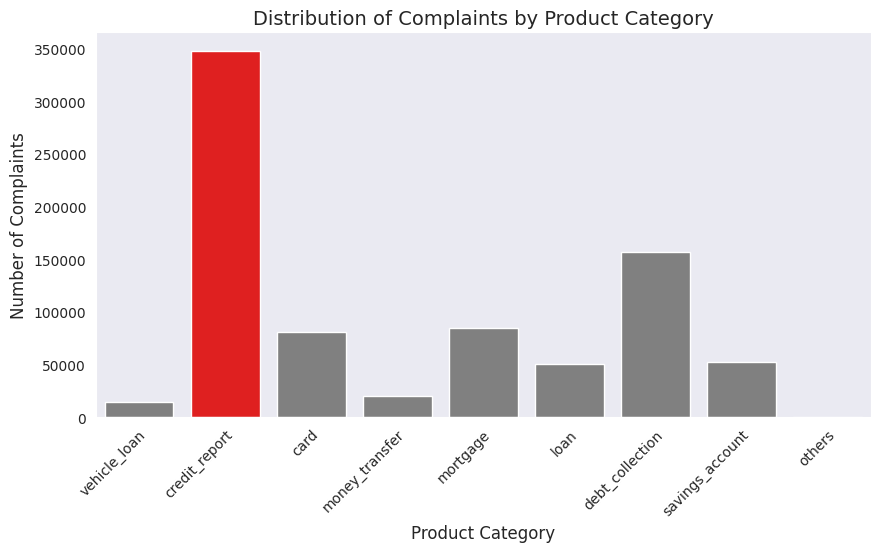

In [14]:
# Set the style for the plot
plt.figure(figsize= (10,5))
sns.set_style('dark')

# Get unique product categories for correct color assignment
unique_products= df['product'].unique()

# Create a custom color palette where 'credit_report' is highlighted in red, and others are gray
colors= ['gray' if product != 'credit_report' else 'red' for product in unique_products]


# Plot the 'product' distribution
ax= sns.countplot(data= df, x= 'product', palette= colors)
plt.xlabel('Product Category', fontsize= 12)
plt.ylabel('Number of Complaints', fontsize= 12)
plt.title('Distribution of Complaints by Product Category', fontsize= 14)
plt.xticks(rotation= 45, ha= 'right', rotation_mode= 'anchor')
plt.show()

### **Analysis of Complaint Distribution by Product Category**

The distribution of complaints reveals several key insights:

- **Credit Report Complaints Dominate**: The majority of complaints in the dataset are related to the **credit report** category, with over 350,000 complaints. This indicates that issues with credit reporting are a major area of concern for consumers.
  
- **Debt Collection**: The second most common complaint category is **debt collection**, which has a significant number of complaints, reflecting ongoing consumer issues related to debt management and recovery.

- **Mortgage Complaints**: **Mortgage**-related complaints also feature prominently, highlighting potential issues in the housing and lending sectors.

- **Lower Complaint Categories**: Categories such as **vehicle loan**, **money transfer**, and **loan** have relatively fewer complaints in comparison to the major categories like credit reporting and debt collection. This may indicate that these areas are either better managed or less prone to issues that lead to complaints.

- **Balanced Categories**: Categories such as **savings account** and **others** have a moderate number of complaints, suggesting more distributed but still notable areas of concern for consumers.

The overall distribution demonstrates that financial products related to **credit reporting** and **debt collection** are the most problematic for consumers, while other categories have significantly fewer complaints. These insights can help identify areas in the financial sector that may need improved customer service or transparency.




In [15]:
# Display the count of complaints for each product category
df['product'].value_counts()

,count
product,
credit_report,348053
debt_collection,157381
mortgage,84461
card,81042
savings_account,52274
loan,50710
money_transfer,20096
vehicle_loan,15034
others,292


In [16]:
# Percentage of the value counts distribution
pct_product= df['product'].value_counts(normalize= True) * 100

# View percentages for each value in the series
pct_product_formatted= pct_product.apply(lambda x: f'{x:.2f}%')

# View percentages
print('Product Category Complaint Distribution Percentage:\n')
pct_product_formatted

Product Category Complaint Distribution Percentage:



,proportion
product,
credit_report,43.00%
debt_collection,19.45%
mortgage,10.44%
card,10.01%
savings_account,6.46%
loan,6.27%
money_transfer,2.48%
vehicle_loan,1.86%
others,0.04%


In [17]:
# Convert the 'complaint' column into a list of complaint texts
complaints= list(df['complaint'])

# Check the total number of complaints in the list
len(complaints)

809343

### **Converting Text to Lower Case**

In Natural Language Processing (NLP), converting text to lower case is an essential preprocessing step. This ensures that words like "Bank" and "bank" are treated the same, eliminating case sensitivity. By standardizing the case, the model can better recognize patterns and reduce redundancy in the text data.

For example, in the context of complaint narratives, a model should not distinguish between "Credit" and "credit" when classifying complaints. Converting all text to lower case ensures consistency and helps improve the accuracy of the text classification model by focusing on the meaning of the words rather than their case.

This step is particularly useful when dealing with large textual datasets, where different cases for the same word could introduce noise into the model training process.


In [18]:
# Convert all complaints to lowercase and strip leading/trailing spaces
complaints= [c.lower().strip() for c in tqdm(complaints)]

# Check specific complaints at index 13 and 3401 to verify the conversion
print(f'Complaint 13: {complaints[13]}')
print(f'Complaint 3401: {complaints[3401]}')

100%|██████████| 809343/809343 [00:01<00:00, 803493.29it/s]

Complaint 13: my credit reports list monies owed to xxxx. i have written to the collection agency, xxxx xxxx xxxx requesting proof that i owe monies on this account, but none was ever sent. i notified the credit agencies that this creditor never sent me the required proof, yet they continue to list this account on my credit report. 

my credit reports list xxxx xxxx xxxx and xxxx for monies owed to xxxx. i submitted documentation that showed that the original creditor was paid however, the credit reporting agencies continue to list xxxx xxxx on my credit report. furthermore, two separate collection agencies can not be listed on my creditreport over the same account. 

my credit reports list a bankruptcy that should have been deleted since the 7 years of reporting it has expired.
Complaint 3401: xxxx xxxx  sent me a email that it looked like my personal data may had been compromised. i opened it up and reviewed everything and there was several unknown inquiries and accounts that certain

### **Tokenization of Text Data**

Tokenization is the process of breaking down text into individual units called tokens, typically words or phrases. In the context of Natural Language Processing (NLP), tokenization is an essential preprocessing step, as it allows the model to interpret text data by breaking it into smaller, manageable components.

By converting the raw text into tokens, it becomes easier to analyze and process the data for tasks like classification, sentiment analysis, and more. For example, in the case of complaint narratives, tokenization transforms each sentence into individual words, which can then be analyzed or vectorized for further modeling.

Tokenization helps:
- Standardize the input text for machine learning models.
- Isolate important features (words) for text analysis.
- Prepare data for further processing steps such as stopword removal, stemming, or lemmatization.

Tokenizing the complaint narratives enables the Naive Bayes model to effectively classify the complaints based on word patterns.


In [19]:
# Tokenize each complaint into individual words
tokens= [word_tokenize(c) for c in tqdm(complaints)]

# Check specifici tokenized complaints for verification
print(f'Tokenized Complaint 13: {tokens[13]}')
print(f'Tokenized Complaint 3401: {tokens[3401]}')

100%|██████████| 809343/809343 [14:52<00:00, 907.20it/s]

Tokenized Complaint 13: ['my', 'credit', 'reports', 'list', 'monies', 'owed', 'to', 'xxxx', '.', 'i', 'have', 'written', 'to', 'the', 'collection', 'agency', ',', 'xxxx', 'xxxx', 'xxxx', 'requesting', 'proof', 'that', 'i', 'owe', 'monies', 'on', 'this', 'account', ',', 'but', 'none', 'was', 'ever', 'sent', '.', 'i', 'notified', 'the', 'credit', 'agencies', 'that', 'this', 'creditor', 'never', 'sent', 'me', 'the', 'required', 'proof', ',', 'yet', 'they', 'continue', 'to', 'list', 'this', 'account', 'on', 'my', 'credit', 'report', '.', 'my', 'credit', 'reports', 'list', 'xxxx', 'xxxx', 'xxxx', 'and', 'xxxx', 'for', 'monies', 'owed', 'to', 'xxxx', '.', 'i', 'submitted', 'documentation', 'that', 'showed', 'that', 'the', 'original', 'creditor', 'was', 'paid', 'however', ',', 'the', 'credit', 'reporting', 'agencies', 'continue', 'to', 'list', 'xxxx', 'xxxx', 'on', 'my', 'credit', 'report', '.', 'furthermore', ',', 'two', 'separate', 'collection', 'agencies', 'can', 'not', 'be', 'listed', 'on

### **Removing Stopwords**

Stopwords are common words in a language that typically carry little meaningful information, such as "the", "is", "in", and "and". These words appear frequently in text but do not contribute significantly to the understanding of the context or content. In Natural Language Processing (NLP), removing stopwords is a common preprocessing step to reduce noise in the data and improve model performance.

By removing stopwords, the focus is shifted to more important words (e.g., nouns, verbs, adjectives) that carry the essential meaning of the text. This step helps in:
- **Reducing dimensionality**: Fewer words in the dataset lead to a more efficient model.
- **Enhancing focus**: The model can concentrate on the more relevant and informative words.
- **Improving performance**: Removing unnecessary words improves the overall quality of the features used for machine learning.

Removing stopwords from the complaint narratives ensures that only the most meaningful words are used in the classification model.


In [22]:
# Load the list of English stopwords from NLTK
sw= stopwords.words('english')

# Display the first 10 stopwords for verification
print(f'First 10 Stopwords: {sw[:10]}')

First 10 Stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [23]:
# Remove stopwords from the tokenized complaints
tokens= [[word for word in t if word not in sw] for t in tqdm(tokens)]

# Display the cleaned tokens for specific complaints to verify stopword removal
print(f'Clean Tokenized Complaint 13: {tokens[13]}')
print(f'Clean Tokenized Complain 3401: {tokens[3401]}')

100%|██████████| 809343/809343 [04:30<00:00, 2994.84it/s]

Clean Tokenized Complaint 13: ['credit', 'reports', 'list', 'monies', 'owed', 'xxxx', '.', 'written', 'collection', 'agency', ',', 'xxxx', 'xxxx', 'xxxx', 'requesting', 'proof', 'owe', 'monies', 'account', ',', 'none', 'ever', 'sent', '.', 'notified', 'credit', 'agencies', 'creditor', 'never', 'sent', 'required', 'proof', ',', 'yet', 'continue', 'list', 'account', 'credit', 'report', '.', 'credit', 'reports', 'list', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'monies', 'owed', 'xxxx', '.', 'submitted', 'documentation', 'showed', 'original', 'creditor', 'paid', 'however', ',', 'credit', 'reporting', 'agencies', 'continue', 'list', 'xxxx', 'xxxx', 'credit', 'report', '.', 'furthermore', ',', 'two', 'separate', 'collection', 'agencies', 'listed', 'creditreport', 'account', '.', 'credit', 'reports', 'list', 'bankruptcy', 'deleted', 'since', '7', 'years', 'reporting', 'expired', '.']
Clean Tokenized Complain 3401: ['xxxx', 'xxxx', 'sent', 'email', 'looked', 'like', 'personal', 'data', 'may', 'compromi

### **Removing Punctuation Marks**

In Natural Language Processing (NLP), removing punctuation marks is an important preprocessing step. Punctuation (e.g., commas, periods, exclamation marks) generally does not add any meaningful information in tasks like text classification. By removing punctuation, the text is simplified, allowing the model to focus solely on the words and their meaning.

Key reasons to remove punctuation include:
- **Standardization**: Punctuation can create variations in text that are unnecessary for analysis (e.g., "hello!" and "hello" are treated the same after punctuation removal).
- **Reducing Noise**: Punctuation marks do not contribute to the sentiment or meaning of the text and can be considered noise in most NLP tasks.
- **Improving Efficiency**: By removing punctuation, the overall dimensionality of the text data is reduced, allowing the model to train more efficiently and effectively.

Punctuation is removed from the complaint narratives to ensure that only the words themselves are analyzed, which improves the quality and focus of the data used for classification.


In [24]:
# Remove punctuation marks
tokenizer= RegexpTokenizer(r'\w+')

# Apply the tokenizer to remove punctuations from each word
tokens= [[''.join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]

# Display cleaned tokenized complaints to verify punctuation removal
print(f'Tokens After Punctuation Removal- Complaint 13: {tokens[13]}')
print(f'Tokens After Punctuation Removal- Complaint 3401: {tokens[3401]}')

100%|██████████| 809343/809343 [02:01<00:00, 6635.85it/s]

Tokens After Punctuation Removal- Complaint 13: ['credit', 'reports', 'list', 'monies', 'owed', 'xxxx', 'written', 'collection', 'agency', 'xxxx', 'xxxx', 'xxxx', 'requesting', 'proof', 'owe', 'monies', 'account', 'none', 'ever', 'sent', 'notified', 'credit', 'agencies', 'creditor', 'never', 'sent', 'required', 'proof', 'yet', 'continue', 'list', 'account', 'credit', 'report', 'credit', 'reports', 'list', 'xxxx', 'xxxx', 'xxxx', 'xxxx', 'monies', 'owed', 'xxxx', 'submitted', 'documentation', 'showed', 'original', 'creditor', 'paid', 'however', 'credit', 'reporting', 'agencies', 'continue', 'list', 'xxxx', 'xxxx', 'credit', 'report', 'furthermore', 'two', 'separate', 'collection', 'agencies', 'listed', 'creditreport', 'account', 'credit', 'reports', 'list', 'bankruptcy', 'deleted', 'since', '7', 'years', 'reporting', 'expired']
Tokens After Punctuation Removal- Complaint 3401: ['xxxx', 'xxxx', 'sent', 'email', 'looked', 'like', 'personal', 'data', 'may', 'compromised', 'opened', 'review

In [25]:
# Remove specific tokens 'xxxx' and '000' from the tokenized complaints
tokens= [[t for t in token if t not in ['xxxx', '000']] for token in tqdm(tokens)]

# Display the cleaned tokenized complaints after removing 'xxxx' and '000'
print(f'Tokens After Removing "xxxx" and "000"- Complaint 13: {tokens[13]}')
print(f'Tokens After Removing "xxxx" and "000"- Complaint 3401: {tokens[3401]}')

100%|██████████| 809343/809343 [00:16<00:00, 50207.91it/s]

Tokens After Removing "xxxx" and "000"- Complaint 13: ['credit', 'reports', 'list', 'monies', 'owed', 'written', 'collection', 'agency', 'requesting', 'proof', 'owe', 'monies', 'account', 'none', 'ever', 'sent', 'notified', 'credit', 'agencies', 'creditor', 'never', 'sent', 'required', 'proof', 'yet', 'continue', 'list', 'account', 'credit', 'report', 'credit', 'reports', 'list', 'monies', 'owed', 'submitted', 'documentation', 'showed', 'original', 'creditor', 'paid', 'however', 'credit', 'reporting', 'agencies', 'continue', 'list', 'credit', 'report', 'furthermore', 'two', 'separate', 'collection', 'agencies', 'listed', 'creditreport', 'account', 'credit', 'reports', 'list', 'bankruptcy', 'deleted', 'since', '7', 'years', 'reporting', 'expired']
Tokens After Removing "xxxx" and "000"- Complaint 3401: ['sent', 'email', 'looked', 'like', 'personal', 'data', 'may', 'compromised', 'opened', 'reviewed', 'everything', 'several', 'unknown', 'inquiries', 'accounts', 'certainly', 'belong', 'pu

In [26]:
# Store the cleaned tokenized complaints back into the DataFrame
df['clean_complaints']= tokens

# Display the first few rows to verify the new column
df.head()

,product,complaint,clean_complaints
1,vehicle_loan,I contacted Ally on Friday XX/XX/XXXX after fa...,"[contacted, ally, friday, xxxxxxxx, falling, b..."
7,credit_report,Hello This complaint is against the three cred...,"[hello, complaint, three, credit, reporting, c..."
8,credit_report,I am a victim of Identity Theft & currently ha...,"[victim, identity, theft, currently, experian,..."
10,credit_report,Two accounts are still on my credit history af...,"[two, accounts, still, credit, history, contac..."
13,credit_report,Receiving daily telephone call ( s ) from XXXX...,"[receiving, daily, telephone, call, identifyin..."


In [27]:
# Extract and analyze complaints for the 'loan' product category
loan_complaints= list(df[df['product'] == 'loan']['clean_complaints'])
loan_complaints= [token for complaint in tqdm(loan_complaints) for token in complaint]

# Count the most common words in the loan complaints
counter= Counter(loan_complaints)
print('Most common words in loan complaints:\n', counter.most_common(10))

100%|██████████| 50710/50710 [00:00<00:00, 183880.55it/s]


Most common words in loan complaints:
 [('loan', 108721), ('payment', 69612), ('xxxxxxxx', 54859), ('payments', 54658), ('would', 51778), ('loans', 49381), ('account', 44823), ('credit', 40709), ('told', 38378), ('pay', 36730)]


In [28]:
# Extract and analyze complaints for the 'card' product category
card_complaints= list(df[df['product'] == 'card']['clean_complaints'])
card_complaints= [token for complaint in tqdm(tokens) for token in complaint]

# Count the most common words in card complaints
print('Most common words in card complaints:\n', counter.most_common(10))

100%|██████████| 809343/809343 [00:03<00:00, 265918.72it/s]

Most common words in card complaints:
 [('loan', 108721), ('payment', 69612), ('xxxxxxxx', 54859), ('payments', 54658), ('would', 51778), ('loans', 49381), ('account', 44823), ('credit', 40709), ('told', 38378), ('pay', 36730)]


In [29]:
# Count the most common words across all complaints
counter= Counter([t for complaint in tqdm(tokens) for t in complaint])
print('Most common words across all complaints:\n', counter.most_common(10))

100%|██████████| 809343/809343 [00:03<00:00, 269569.94it/s]


Most common words across all complaints:
 [('credit', 1371264), ('account', 1098988), ('xxxxxxxx', 889650), ('report', 632326), ('information', 584507), ('would', 478585), ('payment', 472922), ('loan', 425411), ('debt', 413992), ('bank', 379931)]


In [30]:
# Check the total number of unique words
print(f'Number of unique words:\n{len(counter.keys())}')

Number of unique words:
243338


In [62]:
# Join the cleaned tokens back into sequences for each complaint
clean_complaints= [' '.join(complaint) for complaint in tqdm(tokens)]

# Display the cleaned text for verification
print(f'Cleaned Complaint Row 13: {clean_complaints[13]}')
print(f'Cleaned Complaint Row 3401: {clean_complaints[3401]}')

100%|██████████| 809343/809343 [00:02<00:00, 333634.86it/s]

Cleaned Complaint Row 13: credit reports list monies owed written collection agency requesting proof owe monies account none ever sent notified credit agencies creditor never sent required proof yet continue list account credit report credit reports list monies owed submitted documentation showed original creditor paid however credit reporting agencies continue list credit report furthermore two separate collection agencies listed creditreport account credit reports list bankruptcy deleted since 7 years reporting expired
Cleaned Complaint Row 3401: sent email looked like personal data may compromised opened reviewed everything several unknown inquiries accounts certainly belong pulled credit make sure accounts reporting definitely mine please remove items report bankruptcy chapter xxxxdismissed


### Vectorization in NLP

**Vectorization** is the process of converting text data into a numerical format that can be used by machine learning models. In Natural Language Processing (NLP), text is represented as vectors where each word or token is mapped to a unique number in a sparse matrix. This allows models to process textual data effectively.

**CountVectorizer** is used to convert the cleaned text into a document-term matrix, where each row represents a customer complaint and each column represents a word or token that appears in at least 4 complaints. The values in the matrix represent the frequency of each word in the complaints.



In [63]:
# Initialize the CountVectorizer
vect= CountVectorizer(min_df= 200)

# Fit the vectorizer on the clean complaints and transform the data into a document-term matrix
X= vect.fit_transform(clean_complaints)

# Display the shape of the resulting matrix
print(f'Shape of document-term matrix: {X.shape}')

Shape of document-term matrix: (809343, 8547)


In [64]:
# Define the target feature
y= df['product']

# Split the data into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42)

# Display the shape of the data splits
print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (647474, 8547)
y_train Shape: (647474,)
X_test Shape: (161869, 8547)
y_test Shape: (161869,)


### Multinomial Naive Bayes for Text Classification

**Naive Bayes** is a simple yet effective probabilistic classifier that applies **Bayes' Theorem** with the assumption of conditional independence between features. It calculates the probability of a class given a set of features based on prior knowledge and the likelihood of observing the features in that class.

#### What is Naive Bayes?
Naive Bayes is a family of algorithms based on **Bayes' Theorem**:

P(C|X) = (P(X|C) * P(C)) / P(X)

Where:
- **P(C|X)** is the probability of class **C** given features **X**.
- **P(X|C)** is the likelihood of observing the features in class **C**.
- **P(C)** is the prior probability of class **C**.
- **P(X)** is the prior probability of the features.

Naive Bayes is called "naive" because it assumes that all features are independent of each other, which simplifies the computation and works well in many practical applications.

#### Multinomial Naive Bayes
The **Multinomial Naive Bayes** algorithm is used for classification tasks with discrete data, such as word counts or frequencies. It is commonly used in text classification tasks, where the features are the frequency of words in a document, and the goal is to classify the document into one of several categories.

#### Why Choose Multinomial Naive Bayes for Text Classification?
- **Effective for NLP**: Multinomial Naive Bayes performs well on text data, where features are word frequencies. It captures the relevance of word occurrence in relation to the target categories.
- **Efficient for Large Datasets**: This algorithm is computationally efficient, allowing it to handle large datasets and high-dimensional text data.
- **Works Well with Multi-Class Classification**: Multinomial Naive Bayes is ideal for multi-class classification tasks, such as this one, where customer complaints need to be classified into various product categories.
- **Scalable**: The model is scalable, even with a large number of features, making it suitable for the text-heavy data often encountered in Natural Language Processing (NLP).




In [65]:
# Initialize the Multinomial Naive Bayes model
model= MultinomialNB()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
test_pred= model.predict(X_test)

# Calculate the accuracy of the model
accuracy= accuracy_score(y_test, test_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.787371269359791


### Model Accuracy

The accuracy of the model is **78.74%**, meaning that the model correctly classified approximately **79 out of every 100** customer complaints into the correct product category.

This metric gives a general sense of how well the model is performing, but it's important to remember that accuracy alone doesn't capture all aspects of model performance, especially in cases of class imbalance.


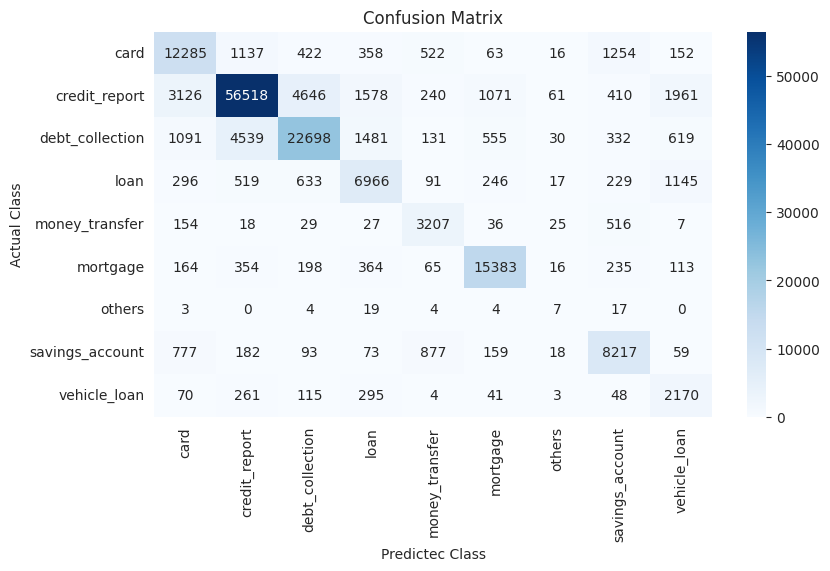

In [70]:
# Compute the confusion matrix
cm= confusion_matrix(y_test, test_pred)

# Convert the confusion matrix to a DataFrame for visualization
cm= pd.DataFrame(cm, columns= model.classes_, index= model.classes_)

# Plot the confusion matrix
plt.figure(figsize= (9,5))
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues')
plt.xlabel('Predictec Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of how well the model is classifying complaints into various product categories. Each row represents the **actual class** of a complaint, while each column represents the **predicted class**. The diagonal elements represent correctly classified complaints, while off-diagonal elements indicate misclassifications.

- The model performs well in classifying complaints related to **credit reports**, with **56,518** correct predictions.
- **Debt collection** also shows strong performance with **22,698** correct predictions.
- However, some product categories like **others** and **money transfer** show fewer correct predictions, suggesting the model struggles more with these categories.
- The misclassifications are most frequent between **similar classes** such as **credit reports** and **debt collection**, which could be due to overlapping complaint content.

Overall, while the model performs well on major classes, there's room for improvement in differentiating between more niche categories.


In [73]:
# Path to Google drive folder
output_dir= '/content/drive/My Drive/Colab Notebooks'

# Save the vectorizer object to my drive
with open(os.path.join(output_dir, 'count_vect.pkl'), 'wb') as f:
  pickle.dump(vect, f)

# Save the Naive Bayes model to my drive
with open(os.path.join(output_dir, 'nb.pkl'), 'wb') as f:
  pickle.dump(model, f)

print('Vectorizer and model saved successfully to Google drive!')

Vectorizer and model saved successfully to Google drive!


In [74]:
# Fetch the complaints and their actual product categories
test_complaint_1= df['complaint'][1545]
test_complaint_2= df['complaint'][5001]

# Check the actual product categories
print(f'Actual Product Category of Complaint 1545: {df["product"][1545]}')
print(f'Actual Product Category of Complaint 5001: {df["product"][5001]}')

Actual Product Category of Complaint 1545: debt_collection
Actual Product Category of Complaint 5001: card


In [75]:
# Combine the complaints into a list for prediction
test_complaint= [test_complaint_1, test_complaint_2]

# Display the selected test complaints
print(f'Test Complaint 1: {test_complaint_1}')
print(f'Test Complaint 2: {test_complaint_2}')

Test Complaint 1: I have a debt of Bank of America which was written off by the bank XX/XX/XXXX without my knowledge. I went to the bank XXXX XXXX since a law group kept on delving on XXXX XXXX Clerk File and garnishing salary from my work.This case has been closed.I paid a lesser amount to the bank to close this debt XXXX I sent them checks. I will greatly appreciate if this case will be resolve.
Test Complaint 2: This is a personal Delta American Express charge card. I am a 30 year customer with American Express. I suddenly, without notice or warning have noted that " Charging Privileges Have Been Suspended ''. The card is current, with no money owed. This notice is only available online and I never received ANY written advice of this action. My account is not " paperless ''. At the phone number provided to call for information, after nearly an hour on the phone THREE TIMES, no explanation was ever provided and I was advised I " would be contacted '' to explain the ( lack of ) issue.

In [76]:
# Load the vectorizer and the Naive Bayes model
vect= pickle.load(open('/content/drive/My Drive/Colab Notebooks/count_vect.pkl', 'rb'))
model= pickle.load(open('/content/drive/My Drive/Colab Notebooks/nb.pkl', 'rb'))

print('Vectorizer and model loaded successfully!')

Vectorizer and model loaded successfully!


In [79]:
# Convert the test complaints to lower case
test_complaint= [r.lower() for r in test_complaint]

# Tokenize the test complaints
test_tokens= [word_tokenize(r) for r in test_complaint]

# Remove stopwords
test_tokens= [[word for word in t if word not in sw] for t in test_tokens]

# Remove punctuations
test_tokens= [[''.join(tokenizer.tokenize(word)) for word in t if len(tokenizer.tokenize(word)) > 0] for t in test_tokens]

# Remove placeholder tokens 'xxxx' and '000'
test_tokens= [[t for t in token if t not in ['xxxx', '000']] for token in test_tokens]

# Join the tokens back into cleaned test complaints
clean_test_complaints= [' '.join(complaint) for complaint in test_tokens]

# Display the clean test complaints for verification
print(f'Clean Test Complaint 1: {clean_test_complaints[0]}')
print(f'Clean Test Complaint 2: {clean_test_complaints[1]}')

Clean Test Complaint 1: debt bank america written bank xxxxxxxx without knowledge went bank since law group kept delving clerk file garnishing salary workthis case closedi paid lesser amount bank close debt sent checks greatly appreciate case resolve
Clean Test Complaint 2: personal delta american express charge card 30 year customer american express suddenly without notice warning noted charging privileges suspended card current money owed notice available online never received written advice action account paperless phone number provided call information nearly hour phone three times explanation ever provided advised would contacted explain lack issue never contacted accumulated miles points card access charge privileges suspended unable obtain information


In [80]:
# Vectorize the test complaints using the loaded vectorizer
X_test= vect.transform(clean_test_complaints)

# Make predictions using the loaded Naive Bayes model
test_preds= model.predict(X_test)

# Display the predictions
print(f'Predicted Product for Test Complaint 1: {test_preds[0]}')
print(f'Predicted Product for Test Complaint 2: {test_pred[1]}')

Predicted Product for Test Complaint 1: debt_collection
Predicted Product for Test Complaint 2: card


In [81]:
# Display the actual product categories for comparison
print(f"Actual Product for Test Complaint 1: {df['product'][1545]}")
print(f"Actual Product for Test Complaint 2: {df['product'][5001]}")

Actual Product for Test Complaint 1: debt_collection
Actual Product for Test Complaint 2: card


- Great! It looks like the predictions are working as expected!